# Distillation de connaissances dans un réseau de neurone

In [2]:
import itertools
import math
import time
import os
import torch
import torchinfo
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch import Tensor, optim
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
import detectors
import timm

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [47]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU - training will be slow!")

✓ Using Apple Silicon GPU (MPS)


# DATA SET : MNIST

In [ ]:
# set batch_size
batch_size = 128

# the data, shuffled and split between train and test sets
# we normalize data to have values between -1 and 1
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]) ])

train_dataset = torchvision.datasets.MNIST(root='data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iterator = iter(train_loader)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.55MB/s]


In [ ]:
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


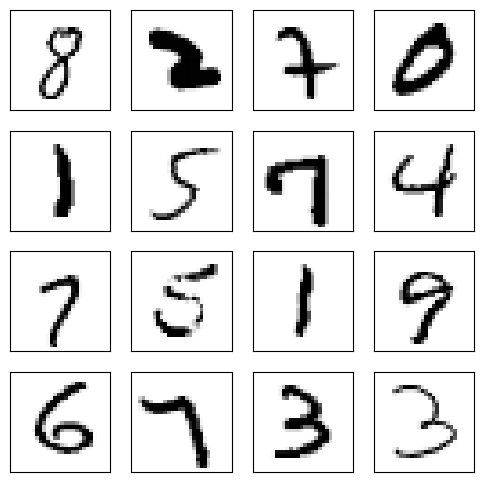

In [ ]:
num_test_samples = 16 # number of digits to plot

# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# load a batch of training data
images, labels = next(train_iterator)

# show a subpart of it
for k in range(num_test_samples):
    i = k//4
    j = k%4
    ax[i,j].cla()
    ax[i,j].imshow(images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)

# Réseau de classification classique

In [ ]:
class ConvBlock(nn.Module):
    """
    Basic convolutional block: Conv → ReLU → Conv → ReLU
    Used for classification
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

## The teacher

### Model

In [ ]:
class Discriminator256channels(nn.Module):
    def __init__(self):
        super().__init__()
        # level 1: 1*28*28
        self.conv1 = ConvBlock(1, 64)
        self.pool1 = nn.MaxPool2d(2)  # → 64*14×14

        # level 2: 64*14*14
        self.conv2 = ConvBlock(64,128)
        self.pool2 = nn.MaxPool2d(2) # → 128*7×7

        # level 3: 128*7*7
        self.conv3 = ConvBlock(128,256)
        self.pool3 = nn.MaxPool2d(2) # → 256*3×3

        #final classifier
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 256 * 3 * 3, out_features=256)
        self.linear2 = nn.Linear(in_features=256,out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        features = x.view(x.size(0), 1, 28, 28)

        x1 = self.conv1(features)
        features = self.pool1(x1)

        x2 = self.conv2(features)
        features = self.pool2(x2)

        x3 = self.conv3(features)
        features = self.pool3(x3)

        out = self.flatten(features)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)

        return out

In [ ]:
# Instantiate model
teacher_model = Discriminator256channels().to(device)

In [ ]:
# Model summary
print("\nDiscriminator Architecture:")
torchinfo.summary(teacher_model, input_size=(1, 1, 28, 28), device=device)


Discriminator Architecture:


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator256channels                 [1, 10]                   --
├─ConvBlock: 1-1                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           36,928
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
├─MaxPool2d: 1-2                         [1, 64, 14, 14]           --
├─ConvBlock: 1-3                         [1, 128, 14, 14]          --
│    └─Conv2d: 2-5                       [1, 128, 14, 14]          73,856
│    └─ReLU: 2-6                         [1, 128, 14, 14]          --
│    └─Conv2d: 2-7                       [1, 128, 14, 14]          147,584
│    └─ReLU: 2-8                         [1, 128, 14, 14]          --
├─MaxPool2d: 1-4                         [1, 128, 7, 7]            --
├

### Training Configuration

In [ ]:
# Hyperparameters
EPOCHS = 5
LEARNING_RATE = 5e-4

# Loss function: Binary Cross Entropy for binary segmentation
# Input: (B, 1, 10) probabilities after sigmoid, Target: (B,) probability expextation between 0,1,2,3,4,5,6,7,8,9
# We use BCELoss since Sigmoid is already applied in the model
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(teacher_model.parameters(), lr=LEARNING_RATE)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


### Training loop

In [ ]:
from tqdm import tqdm

for epoch in range(EPOCHS):
    teacher_model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{EPOCHS}",
        leave=True
    )

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # forward
        logits = teacher_model(images)
        loss = criterion(logits, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # update progress bar
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{100 * correct / total:.2f}%"
        })


Epoch 5/5: 100%|██████████| 469/469 [00:51<00:00,  9.09it/s, loss=0.0289, acc=99.37%]


In [ ]:
torch.save(teacher_model.state_dict(), "teacher_mnist.pth")

## Smaller model : less channels

### model

In [ ]:
class Discriminator32channels(nn.Module):
    def __init__(self):
        super().__init__()
        # level 1: 1*28*28
        self.conv1 = ConvBlock(1, 8)
        self.pool1 = nn.MaxPool2d(2)  # → 8*14×14

        # level 2: 8*14*14
        self.conv2 = ConvBlock(8,16)
        self.pool2 = nn.MaxPool2d(2) # → 16*7×7

        # level 3: 16*7*7
        self.conv3 = ConvBlock(16,32)
        self.pool3 = nn.MaxPool2d(2) # → 32*3×3

        #final classifier
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 32 * 3 * 3, out_features=32)
        self.linear2 = nn.Linear(in_features=32,out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        features = x.view(x.size(0), 1, 28, 28)

        x1 = self.conv1(features)
        features = self.pool1(x1)

        x2 = self.conv2(features)
        features = self.pool2(x2)

        x3 = self.conv3(features)
        features = self.pool3(x3)

        out = self.flatten(features)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)

        return out

In [ ]:
class Discriminator16channels(nn.Module):
    def __init__(self):
        super().__init__()
        # level 1: 1*28*28
        self.conv1 = ConvBlock(1, 4)
        self.pool1 = nn.MaxPool2d(2)  # → 4*14×14

        # level 2: 4*14*14
        self.conv2 = ConvBlock(4,8)
        self.pool2 = nn.MaxPool2d(2) # → 8*7×7

        # level 3: 8*7*7
        self.conv3 = ConvBlock(8,16)
        self.pool3 = nn.MaxPool2d(2) # → 16*3×3

        #final classifier
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 16 * 3 * 3, out_features=16)
        self.linear2 = nn.Linear(in_features=16,out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        features = x.view(x.size(0), 1, 28, 28)

        x1 = self.conv1(features)
        features = self.pool1(x1)

        x2 = self.conv2(features)
        features = self.pool2(x2)

        x3 = self.conv3(features)
        features = self.pool3(x3)

        out = self.flatten(features)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)

        return out

In [ ]:
class Discriminator16channelsLessConv(nn.Module):
    def __init__(self):
        super().__init__()
        # level 1: 1*28*28
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # → 4*14×14

        # level 2: 4*14*14
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2) # → 8*7×7

        # level 3: 8*7*7
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2) # → 16*3×3

        #final classifier
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 16 * 3 * 3, out_features=32)
        self.linear2 = nn.Linear(in_features=32,out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        features = x.view(x.size(0), 1, 28, 28)

        x1 = self.conv1(features)
        x1 = self.relu(x1)
        features = self.pool1(x1)

        x2 = self.conv2(features)
        x2 = self.relu(x2)
        features = self.pool2(x2)

        x3 = self.conv3(features)
        x3 = self.relu(x3)
        features = self.pool3(x3)

        out = self.flatten(features)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)

        return out

In [ ]:
class Discriminator8channelsLessConv(nn.Module):
    def __init__(self):
        super().__init__()
        # level 1: 1*28*28
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # → 4*14×14

        # level 2: 4*14*14
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2) # → 8*7×7

        # level 3: 8*7*7
        self.pool3 = nn.MaxPool2d(2) # → 8*3×3

        #final classifier
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(in_features= 8 * 3 * 3, out_features=32)
        self.linear2 = nn.Linear(in_features=32,out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        features = x.view(x.size(0), 1, 28, 28)

        x1 = self.conv1(features)
        x1 = self.relu(x1)
        features = self.pool1(x1)

        x2 = self.conv2(features)
        x2 = self.relu(x2)
        features = self.pool2(x2)

        x3 = self.relu(features)
        features = self.pool3(x3)

        out = self.flatten(features)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)

        return out

In [ ]:
class Discriminator2Conv4channels(nn.Module):
    def __init__(self):
        super().__init__()
        # level 1: 1*28*28
        self.conv1 = nn.Conv2d(1, 2, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # → 2*14×14

        # level 2: 2*14*14
        self.conv2 = nn.Conv2d(2,4, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2) # → 4*7×7


        #final classifier
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=4*7*7,out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        features = x.view(x.size(0), 1, 28, 28)

        x1 = self.conv1(features)
        x1 = self.relu(x1)
        features = self.pool1(x1)

        x2 = self.conv2(features)
        x2 = self.relu(x2)
        features = self.pool2(x2)

        out = self.flatten(features)
        out = self.linear(out)

        return out

In [ ]:
class Discriminator1Conv4channels(nn.Module):
    def __init__(self):
        super().__init__()
        # level 1: 1*28*28
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # → 4*14×14


        #final classifier
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=4*3*3,out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        features = x.view(x.size(0), 1, 28, 28)

        x1 = self.conv1(features)
        x1 = self.relu(x1)
        features = self.pool1(x1)
        features = self.pool1(features)
        features = self.pool1(features)

        out = self.flatten(features)
        out = self.linear(out)

        return out

In [ ]:
# Instantiate model
small_model = Discriminator2Conv4channels().to(device)

In [ ]:
# Model summary
print("\nDiscriminator Architecture:")
torchinfo.summary(small_model, input_size=(1, 1, 28, 28), device=device)


Discriminator Architecture:


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator2Conv4channels              [1, 10]                   --
├─Conv2d: 1-1                            [1, 2, 28, 28]            20
├─ReLU: 1-2                              [1, 2, 28, 28]            --
├─MaxPool2d: 1-3                         [1, 2, 14, 14]            --
├─Conv2d: 1-4                            [1, 4, 14, 14]            76
├─ReLU: 1-5                              [1, 4, 14, 14]            --
├─MaxPool2d: 1-6                         [1, 4, 7, 7]              --
├─Flatten: 1-7                           [1, 196]                  --
├─Linear: 1-8                            [1, 10]                   1,970
Total params: 2,066
Trainable params: 2,066
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03

### Model configuration

In [ ]:
# Hyperparameters
EPOCHS = 5
LEARNING_RATE = 5e-4

# Loss function: Binary Cross Entropy for binary segmentation
# Input: (B, 1, 10) probabilities after sigmoid, Target: (B,) probability expextation between 0,1,2,3,4,5,6,7,8,9
# We use BCELoss since Sigmoid is already applied in the model
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(small_model.parameters(), lr=LEARNING_RATE)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


### Training loop

In [ ]:
from tqdm import tqdm

for epoch in range(EPOCHS):
    small_model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{EPOCHS}",
        leave=True
    )

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # forward
        logits = small_model(images)
        loss = criterion(logits, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # update progress bar
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{100 * correct / total:.2f}%"
        })

Epoch 1/5:   0%|          | 0/391 [00:03<?, ?it/s]
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/myenv/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/myenv/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/torchvision/__init__.py", line 10, in <module>
    from torchvision import _meta_registrations, datasets, io, models, ops, transforms, utils  # usort:skip
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/torchvision/models/__init__.py", line 2, in <module>
    from .convnext import *
  File "/opt/anaconda3/envs/myenv/lib/python3.12

KeyboardInterrupt: 

# Distillation

In [ ]:
teacher = Discriminator256channels().to(device)
teacher.load_state_dict(torch.load("teacher_mnist.pth"))
teacher.eval()

for p in teacher.parameters():
    p.requires_grad = False

student = Discriminator1Conv4channels().to(device)

optimizer = optim.Adam(student.parameters(), lr=LEARNING_RATE)

NameError: name 'Discriminator256channels' is not defined

In [ ]:
T = 6.0
alpha = 0.8

def distillation_loss(student_logits, teacher_logits, labels):
    loss_ce = F.cross_entropy(student_logits, labels)

    loss_kd = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction="batchmean"
    )

    return alpha * loss_ce + (1 - alpha) * (T * T) * loss_kd

In [ ]:
for epoch in range(EPOCHS):
    student.train()
    teacher.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{EPOCHS}",
        leave=True
    )

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # teacher forward (no grad)
        with torch.no_grad():
            teacher_logits = teacher(images)

        # student forward
        student_logits = student(images)

        # distillation loss
        loss = distillation_loss(
            student_logits,
            teacher_logits,
            labels
        )

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item()
        preds = student_logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # progress bar
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{100 * correct / total:.2f}%"
        })

Epoch 2/10:  26%|██▌       | 120/469 [00:04<00:11, 29.23it/s, loss=5.0193, acc=66.30%]


KeyboardInterrupt: 